# ECSE 415 Course Project
**Group 16**

## Part 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys, cv2, csv, os
from skimage.feature import hog
from sklearn import svm
import tensorflow as tf
from sklearn.model_selection import GridSearchCV

As mentioned by the project instruction, we use reference from Facebook Detectron2 site, and the project is run on GPU

In [2]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [5]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


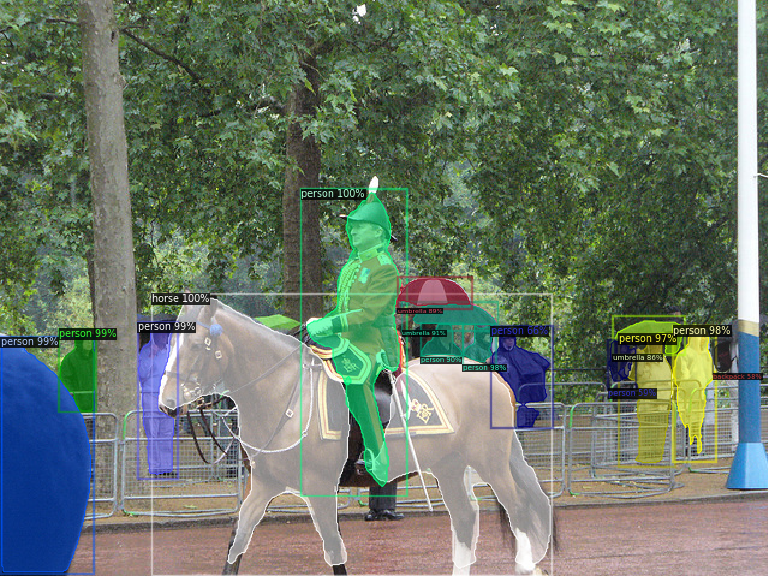

In [7]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

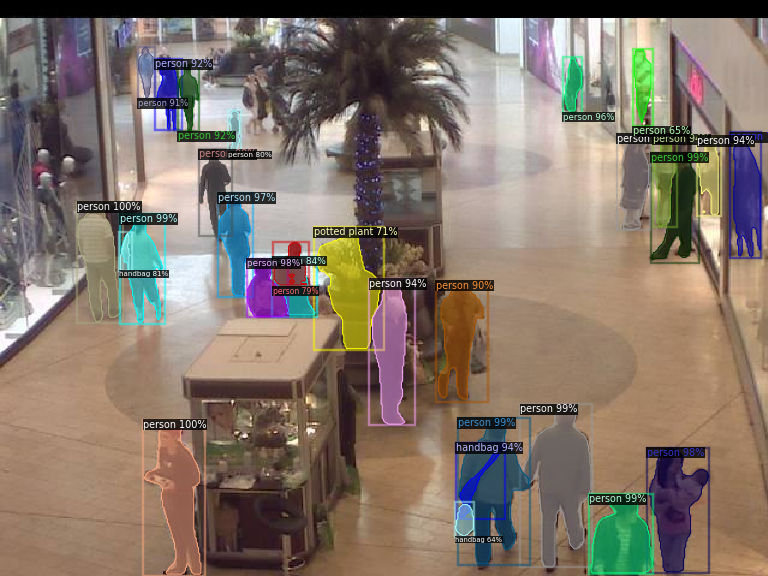

In [8]:
seq_000001 = cv2.imread("./frames/seq_000001.jpg")

outputs = predictor(seq_000001)
v = Visualizer(seq_000001[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [9]:
path ='./frames'
files = os.listdir(path)
my_files = [] 
image_list = []
for i in range(0,2000):
  my_files.append(files[i])
my_files.sort()
for i in range(0,2000):
  image = cv2.imread("./frames/"+my_files[i])
  image_list.append(image)

In [10]:
def snapshot(image, coords):
  output = []
  for i in range(len(coords)):
    person = image[int(coords[i][1]):int(coords[i][3]),int(coords[i][0]):int(coords[i][2])]
    output.append(person)
  return output

In [11]:
def detector(image): 
  detected = []
  predictor = DefaultPredictor(cfg)
  outputs = predictor(image)
  pred_classes = outputs["instances"].get("pred_classes")
  pred_classes = tf.make_ndarray(tf.make_tensor_proto(pred_classes.cpu())) 
  pred_boxes = outputs["instances"].get("pred_boxes")
  pred_boxes = tf.make_ndarray(tf.make_tensor_proto(pred_boxes.tensor.cpu()))
  for i in range (len(pred_classes)):
    if(pred_classes[i] == 0):
      detected.append(pred_boxes[i])
  return detected

In [12]:
detected_person = []
detected_list = []
for i in range (135):
  detected = detector(image_list[i])
  temp_detected_person = snapshot(image_list[i],detected)
  detected_person = detected_person + temp_detected_person

print(len(detected_person))

for i in range(len(detected_person)):
  temp = cv2.cvtColor(detected_person[i], cv2.COLOR_BGR2GRAY)
  detected_list.append(temp)

2997


## Part 2

In [13]:
sum_len = 0
sum_width = 0
for i in range(len(detected_list)):
  sum_len += len(detected_list[i])
  sum_width += len(detected_list[i][0])
avg_len = int(sum_len / len(detected_list))
avg_width = int(sum_width / len(detected_list))
print(avg_len)
print(avg_width)

79
32


In [14]:
positive_boundingbox = []
for i in range(len(detected_list)):
  temp = cv2.resize(detected_list[i], (avg_width,avg_len)) 
  positive_boundingbox.append(temp)

In [15]:
gray_image = cv2.cvtColor(seq_000001, cv2.COLOR_BGR2GRAY)

def sliding_window_negative(image, x_start,x_end,y_start,y_end):
  for i in range(y_start, y_end, 6):
    for j in range(x_start,x_end, 6):
      patch = image[i:i + avg_len,j:j + avg_width]
      yield (i, j), patch

corner1, negative_boundingbox1 = zip(*sliding_window_negative(gray_image,180,400 - avg_width,300, gray_image.shape[0] - avg_len))
corner2, negative_boundingbox2 = zip(*sliding_window_negative(gray_image,0,100,0, 180))
corner3, negative_boundingbox3 = zip(*sliding_window_negative(gray_image,200,460,0, 100))
corner4, negative_boundingbox4 = zip(*sliding_window_negative(gray_image,200,500,200, 300))
corner5, negative_boundingbox5 = zip(*sliding_window_negative(gray_image,400,gray_image.shape[1] - avg_width,200, 330))

In [16]:
negative_boundingbox_len = len(negative_boundingbox1)+len(negative_boundingbox2)+len(negative_boundingbox3)+len(negative_boundingbox4)+len(negative_boundingbox5)
negative_boundingbox = []
for i in range(len(negative_boundingbox1)):
  negative_boundingbox.append(negative_boundingbox1[i])
for i in range(len(negative_boundingbox2)):
  negative_boundingbox.append(negative_boundingbox2[i])
for i in range(len(negative_boundingbox3)):
  negative_boundingbox.append(negative_boundingbox3[i])
for i in range(len(negative_boundingbox4)):
  negative_boundingbox.append(negative_boundingbox4[i])
for i in range(len(negative_boundingbox5)):
  negative_boundingbox.append(negative_boundingbox5[i])

In [17]:
print(len(detected_list))
print(negative_boundingbox_len)

2997
3422


In [18]:
arr1 = np.array(positive_boundingbox)
arr2 = np.array(negative_boundingbox)
final_dataset = np.concatenate((arr1, arr2))

In [19]:
hog_final_dataset = np.array([hog(im) for im in final_dataset])
x_train = hog_final_dataset
y_train = np.zeros(x_train.shape[0])
positive_boundingbox_arr = np.array(positive_boundingbox)
y_train[:positive_boundingbox_arr.shape[0]] = 1

In [20]:
# grid_model = GridSearchCV(svm.SVC(), {'C': [1,2,3,4,5,6],'gamma':[0.1,0.2,0.3,0.4,0.5,0.6],'kernel': ['rbf']})
# grid_model.fit(x_train, y_train)

In [21]:
# Optimized value was found constant to be C=2 and gamma=0.5 for our model.
# Commented out grid search to control training time.
optimized_model = svm.SVC(C=2, gamma=0.5,kernel='rbf',probability=True)
# optimized_model = grid_model.best_estimator_
optimized_model.fit(x_train, y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [22]:
def Non_Max_Suppression(corner_test,boundingbox_hog_test):
  nms_corner_test = []
  tensors_list = []
  tensor_score_list = []
  temp_tensor_score_list = []
  corner_test = np.array(corner_test)
  detected_persons = corner_test[labels == 1]
  penalty = np.zeros(len(detected_persons))
  detected_person_prob_list = optimized_model.predict_proba(boundingbox_hog_test)
  final_detected_persons = []
  for i in range(len(detected_person_prob_list)):
    if int(labels[i]) == 1:
      tensor_score_list.append(detected_person_prob_list[i][1])
  
  for i in range(len(detected_persons)):
    for j in range(i+1,len(detected_persons)):
      if abs(detected_persons[i][0] - detected_persons[j][0]) < 15 and abs(detected_persons[i][1] - detected_persons[j][1]) < 55:
        tensors_list.append([detected_persons[i][0],detected_persons[i][1],detected_persons[i][0]+avg_width,detected_persons[i][1]+avg_len])
        tensors_list.append([detected_persons[j][0],detected_persons[j][1],detected_persons[j][0]+avg_width,detected_persons[j][1]+avg_len])
        temp_tensor_score_list.append(tensor_score_list[i])
        temp_tensor_score_list.append(tensor_score_list[j])
        boxes = torch.tensor(tensors_list,dtype=torch.float32)
        scores = torch.tensor(temp_tensor_score_list,dtype=torch.float32)
        tensor_result = nms(boxes = boxes, scores = scores, iou_threshold = 0.3)
        if int(tensor_result[0]) == 0:
          penalty[j] = penalty[j] + 1
        else:
          penalty[i] = penalty[i] + 1
      tensors_list = []
      temp_tensor_score_list = []
  new_corner_test = []
  
  for i in range(len(penalty)):
    if int(penalty[i]) == 0:
      new_corner_test.append(detected_persons[i])
  return new_corner_test

In [23]:
def sliding_window(image):
  l, w = (90,40)
  for i in range(20, image.shape[0] - l, 55):
    for j in range(0, image.shape[1] - w, 30):
      temp_patch = image[i:i + l, j:j + w]
      patch = cv2.resize(temp_patch, (avg_width,avg_len)) 
      yield (i, j), patch

In [24]:
path ='./frames'
files = os.listdir(path)
my_files = [] 
image_list = []
for i in range(0,2000):
  my_files.append(files[i])
my_files.sort()
for i in range(0,2000):
  image = cv2.imread("./frames/"+my_files[i],0) # for processing, gray scale
  image_list.append(image)

In [25]:
label_num_list = []

for i in range(len(image_list)):
  # test_image_gray = cv2.cvtColor(image_list[i], cv2.COLOR_BGR2GRAY)
  corner_test, boundingbox_test = zip(*sliding_window(image_list[i]))
  boundingbox_hog_test = np.array([hog(patch) for patch in boundingbox_test])
  labels = optimized_model.predict(boundingbox_hog_test)
  label_num_list.append(int(labels.sum()))

In [26]:
with open('group16_prediction.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["id", "count"])
  for i in range(len(label_num_list)):
    writer.writerow([i+1, label_num_list[i]])

In [27]:
def sliding_window_test(image):
  l, w = (90,40)
  for i in range(20, image.shape[0] - l, 30):
    for j in range(0, image.shape[1] - w, 15):
      temp_patch = image[i:i + l, j:j + w]
      patch = cv2.resize(temp_patch, (avg_width,avg_len)) 
      yield (i, j), patch

In [28]:
test_image_gray = cv2.cvtColor(seq_000001, cv2.COLOR_BGR2GRAY)
corner_test, boundingbox_test = zip(*sliding_window_test(test_image_gray))
boundingbox_hog_test = np.array([hog(patch) for patch in boundingbox_test])
labels = optimized_model.predict(boundingbox_hog_test)

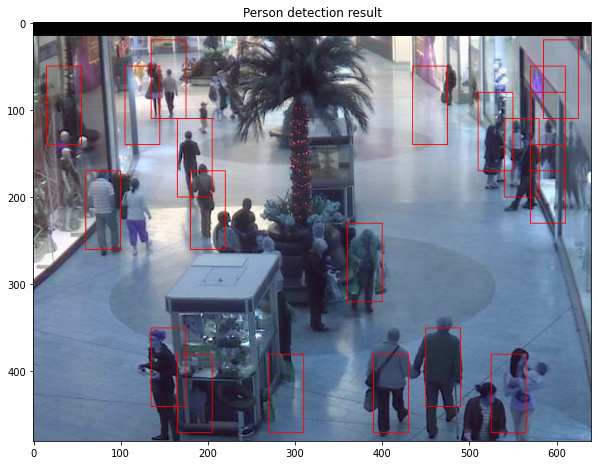

In [29]:
from torchvision.ops import nms
display = cv2.imread("./frames/seq_000001.jpg")
new_corner_test = Non_Max_Suppression(corner_test,boundingbox_hog_test)
new_corner_test = np.array(new_corner_test)
for i in range(len(new_corner_test)):
    cv2.rectangle(display, (int(new_corner_test[i][1]), int(new_corner_test[i][0])), (int(new_corner_test[i][1])+40, int(new_corner_test[i][0])+90), (250,0,0), 1)
plt.figure(figsize=(10, 8))
plt.title('Person detection result')
plt.imshow(display)
plt.show()

In [30]:
def computeIoU(boundingbox1, boundingbox2):
  x1 = max(boundingbox1[0], boundingbox2[0])
  y1 = max(boundingbox1[1], boundingbox2[1])
  x2 = min(boundingbox1[2], boundingbox2[2])
  y2 = min(boundingbox1[3], boundingbox2[3])
  overlap = abs(max((x2 - x1, 0)) * max((y2 - y1), 0))
  
  if overlap == 0:
    return 0  
  IoU = overlap / (abs((boundingbox1[2] - boundingbox1[0]) * (boundingbox1[3] - boundingbox1[1])) + abs((boundingbox2[2] - boundingbox2[0]) * (boundingbox2[3] - boundingbox2[1])) - overlap)
  return IoU

In [31]:
boundingboxes1 = []
output_list = detector(seq_000001)
for i in range(len(output_list)):
  temp_box = [int(output_list[i][1]),int(output_list[i][0]),int(output_list[i][3]),int(output_list[i][2])]
  boundingboxes1.append(temp_box)

In [32]:
boundingboxes2 = []
corner_test = np.array(corner_test)
for i, j in corner_test[labels == 1]:
  boundingboxes2.append([j,i,j+avg_width,i+avg_len])

In [33]:
iou_list = []
for i in range(len(boundingboxes1)):
  for j in range(len(boundingboxes2)):
    if (abs(boundingboxes1[i][0] - boundingboxes2[j][0])<20) and (abs(boundingboxes1[i][1] - boundingboxes2[j][1])<20):
      iou_list.append(computeIoU(boundingboxes1[i], boundingboxes2[j]))
avg_iou = 0
for i in range(len(iou_list)):
  avg_iou = avg_iou + iou_list[i]
avg_iou = avg_iou / len(iou_list)
print(avg_iou)

0.08272853524546972
